In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from IPython.display import display, HTML
pd.set_option('display.max_columns', None)
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix,roc_curve
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import warnings
warnings.simplefilter('ignore', DeprecationWarning)

# Fairness Analysis - Germen Credit Risk

# Model training

### This part is adapted from https://www.kaggle.com/pahulpreet/german-credit-risk-analysis-beginner-s-guide.

In [2]:
df = pd.read_csv("http://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.data", sep=" ", header=None)
headers = ["Status of existing checking account", "Duration in month", "Credit history",
           "Purpose", "Credit amount", "Savings account/bonds", "Present employment since",
           "Installment rate in percentage of disposable income", "Personal status and sex",
           "Other debtors / guarantors", "Present residence since", "Property", "Age in years",
           "Other installment plans", "Housing", "Number of existing credits at this bank",
           "Job", "Number of people being liable to provide maintenance for", 
           "Telephone", "foreign worker", "Cost Matrix(Risk)"]
df.columns = headers
df.to_csv("german_data_credit_cat.csv", index=False)

In [3]:
Status_of_existing_checking_account={'A14':"no checking account",'A11':"<0 DM", 'A12': "0 <= <200 DM",'A13':">= 200 DM "}
df["Status of existing checking account"]=df["Status of existing checking account"].map(Status_of_existing_checking_account)

Credit_history={"A34":"critical account","A33":"delay in paying off","A32":"existing credits paid back duly till now","A31":"all credits at this bank paid back duly","A30":"no credits taken"}
df["Credit history"]=df["Credit history"].map(Credit_history)

Purpose={"A40" : "car (new)", "A41" : "car (used)", "A42" : "furniture/equipment", "A43" :"radio/television" , "A44" : "domestic appliances", "A45" : "repairs", "A46" : "education", 'A47' : 'vacation','A48' : 'retraining','A49' : 'business','A410' : 'others'}
df["Purpose"]=df["Purpose"].map(Purpose)

Saving_account={"A65" : "no savings account","A61" :"<100 DM","A62" : "100 <= <500 DM","A63" :"500 <= < 1000 DM", "A64" :">= 1000 DM"}
df["Savings account/bonds"]=df["Savings account/bonds"].map(Saving_account)

Present_employment={'A75':">=7 years", 'A74':"4<= <7 years",  'A73':"1<= < 4 years", 'A72':"<1 years",'A71':"unemployed"}
df["Present employment since"]=df["Present employment since"].map(Present_employment)

# Personal_status_and_sex={ 'A95':"female:single",'A94':"male:married/widowed",'A93':"male:single", 'A92':"female:divorced/separated/married", 'A91':"male:divorced/separated"}
Sex = {'A95':"female",'A94':"male",'A93':"male", 'A92':"female", 'A91':"male"}
df['Sex'] = df["Personal status and sex"].map(Sex)
Personal_status={ 'A95':"single",'A94':"married/widowed",'A93':"single", 'A92':":divorced/separated/married", 'A91':"divorced/separated"}
df["Personal status"]=df["Personal status and sex"].map(Personal_status)

Other_debtors_guarantors={'A101':"none", 'A102':"co-applicant", 'A103':"guarantor"}
df["Other debtors / guarantors"]=df["Other debtors / guarantors"].map(Other_debtors_guarantors)

Property={'A121':"real estate", 'A122':"savings agreement/life insurance", 'A123':"car or other", 'A124':"unknown / no property"}
df["Property"]=df["Property"].map(Property)

Other_installment_plans={'A143':"none", 'A142':"store", 'A141':"bank"}
df["Other installment plans"]=df["Other installment plans"].map(Other_installment_plans)

Housing={'A153':"for free", 'A152':"own", 'A151':"rent"}
df["Housing"]=df["Housing"].map(Housing)

Job={'A174':"management/ highly qualified employee", 'A173':"skilled employee / official", 'A172':"unskilled - resident", 'A171':"unemployed/ unskilled  - non-resident"}
df["Job"]=df["Job"].map(Job)

Telephone={'A192':"yes", 'A191':"none"}
df["Telephone"]=df["Telephone"].map(Telephone)

foreign_worker={'A201':"yes", 'A202':"no"}
df["foreign worker"]=df["foreign worker"].map(foreign_worker)

risk={1:"Good Risk", 2:"Bad Risk"}
df["Cost Matrix(Risk)"]=df["Cost Matrix(Risk)"].map(risk)

In [4]:
cat_col = ["Status of existing checking account", "Credit history", "Purpose", "Savings account/bonds", 
           "Present employment since", "Personal status", "Sex", "Other debtors / guarantors", "Property",
           "Other installment plans", "Housing", "Job", "Telephone", "foreign worker"]
num_col = ["Duration in month", "Credit amount", "Installment rate in percentage of disposable income",
           "Present residence since", "Age in years", "Number of existing credits at this bank",
           "Number of people being liable to provide maintenance for"]
target =  "Cost Matrix(Risk)"

In [27]:
cat_df = df[cat_col]
for attr in cat_col:
    cat_df = cat_df.merge(pd.get_dummies(cat_df[attr], prefix=attr, drop_first=True), left_index=True, right_index=True)
    cat_df.drop(attr, axis=1, inplace=True)

In [28]:
risk = {"Good Risk":1, "Bad Risk":0}
cat_df["Cost Matrix(Risk)"] = df["Cost Matrix(Risk)"].map(risk)

In [29]:
cat_df.head(5)

,Status of existing checking account_<0 DM,Status of existing checking account_>= 200 DM,Status of existing checking account_no checking account,Credit history_critical account,Credit history_delay in paying off,Credit history_existing credits paid back duly till now,Credit history_no credits taken,Purpose_car (new),Purpose_car (used),Purpose_domestic appliances,Purpose_education,Purpose_furniture/equipment,Purpose_others,Purpose_radio/television,Purpose_repairs,Purpose_retraining,Savings account/bonds_500 <= < 1000 DM,Savings account/bonds_<100 DM,Savings account/bonds_>= 1000 DM,Savings account/bonds_no savings account,Present employment since_4<= <7 years,Present employment since_<1 years,Present employment since_>=7 years,Present employment since_unemployed,Personal status_divorced/separated,Personal status_married/widowed,Personal status_single,Sex_male,Other debtors / guarantors_guarantor,Other debtors / guarantors_none,Property_real estate,Property_savings agreement/life insurance,Property_unknown / no property,Other installment plans_none,Other installment plans_store,Housing_own,Housing_rent,Job_skilled employee / official,Job_unemployed/ unskilled - non-resident,Job_unskilled - resident,Telephone_yes,foreign worker_yes,Cost Matrix(Risk)
0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,1,1,0,1,1,0,0,1,0,1,0,1,0,0,1,1,1
1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,1,0,1,0,0,0,1,0
2,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,1,0,1,1,0,0,1,0,1,0,0,0,1,0,1,1
3,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,1,1,0,0,1,0,1,0,0,0,1,0,0,0,1,1
4,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,1,0,0,1,1,0,0,0,1,0,0,0,1,0


In [30]:
num_df = df[num_col]

In [31]:
encoded = pd.concat([num_df, cat_df], axis=1)

In [58]:
encoded.head(5)

,Duration in month,Credit amount,Installment rate in percentage of disposable income,Present residence since,Age in years,Number of existing credits at this bank,Number of people being liable to provide maintenance for,Status of existing checking account_<0 DM,Status of existing checking account_>= 200 DM,Status of existing checking account_no checking account,Credit history_critical account,Credit history_delay in paying off,Credit history_existing credits paid back duly till now,Credit history_no credits taken,Purpose_car (new),Purpose_car (used),Purpose_domestic appliances,Purpose_education,Purpose_furniture/equipment,Purpose_others,Purpose_radio/television,Purpose_repairs,Purpose_retraining,Savings account/bonds_500 <= < 1000 DM,Savings account/bonds_<100 DM,Savings account/bonds_>= 1000 DM,Savings account/bonds_no savings account,Present employment since_4<= <7 years,Present employment since_<1 years,Present employment since_>=7 years,Present employment since_unemployed,Personal status_divorced/separated,Personal status_married/widowed,Personal status_single,Sex_male,Other debtors / guarantors_guarantor,Other debtors / guarantors_none,Property_real estate,Property_savings agreement/life insurance,Property_unknown / no property,Other installment plans_none,Other installment plans_store,Housing_own,Housing_rent,Job_skilled employee / official,Job_unemployed/ unskilled - non-resident,Job_unskilled - resident,Telephone_yes,foreign worker_yes,Cost Matrix(Risk)
0,6,1169,4,4,67,2,1,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,1,1,0,1,1,0,0,1,0,1,0,1,0,0,1,1,1
1,48,5951,2,2,22,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,1,0,1,0,0,0,1,0
2,12,2096,2,3,49,1,2,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,1,0,1,1,0,0,1,0,1,0,0,0,1,0,1,1
3,42,7882,2,4,45,1,2,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,1,1,0,0,1,0,1,0,0,0,1,0,0,0,1,1
4,24,4870,3,4,53,2,2,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,1,0,0,1,1,0,0,0,1,0,0,0,1,0


In [32]:
train, test = train_test_split(encoded, test_size=0.2, random_state=0)

In [34]:
X = train.drop(columns=[target]).values
Y = train[target]
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

In [35]:
model = XGBClassifier()

In [36]:
xgb_params = {'learning_rate': [0.03, 0.1, 0.3, 1],
              'max_depth': [3, 4, 5, 6, 7],
              'min_child_weight': [1, 2, 3, 4]}
xgb = XGBClassifier(random_state=0, verbosity=0)

In [37]:
from sklearn.metrics import make_scorer

def my_custom_loss_func(y_true, y_pred):
    prediction = 1 if y_pred > 0.5 else 0
    if y_true == prediction:
        return 0
    elif y_true == 1:
        return 1
    else:
        return 5

score = make_scorer(my_custom_loss_func, greater_is_better=False)

In [38]:
xgb_cv_model = GridSearchCV(xgb, xgb_params, cv=5, verbose=5, scoring='accuracy', refit=True, n_jobs=6, return_train_score=True)
xgb_cv_model.fit(X, Y)

Fitting 5 folds for each of 80 candidates, totalling 400 fits
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   6 tasks      | elapsed:    1.8s
[Parallel(n_jobs=6)]: Done  60 tasks      | elapsed:    3.6s
[Parallel(n_jobs=6)]: Done 150 tasks      | elapsed:    7.2s
[Parallel(n_jobs=6)]: Done 276 tasks      | elapsed:   12.7s
[Parallel(n_jobs=6)]: Done 400 out of 400 | elapsed:   17.7s finished


GridSearchCV(cv=5, error_score=nan,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estim...
                                     random_state=0, reg_alpha=None,
                                     reg_lambda=None, scale_pos_weight=None,
                                     subsample=None, tree_method=None,
                                     validate_parameters=None, ver

In [39]:
xgb_cv_model.best_params_

{'learning_rate': 0.3, 'max_depth': 5, 'min_child_weight': 2}

In [40]:
xgb_cv_results = pd.DataFrame(xgb_cv_model.cv_results_)
xgb_best_result = xgb_cv_results[xgb_cv_results['rank_test_score'] == 1].iloc[0]
xgb_avg_val_score, xgb_std_val_score = xgb_best_result[['mean_test_score', 'std_test_score']]
xgb_avg_train_score, xgb_std_train_score = xgb_best_result[['mean_train_score', 'std_train_score']]

xgb_split_results = xgb_best_result[[idx for idx in xgb_best_result.index if 'split' in idx]]

print('TRAINING CV RESULTS (Accuracy)')
print('Train:')
print('Mean: ', xgb_avg_train_score)
print('Std. Dev.: ', xgb_std_train_score)
print('Validation:')
print('Mean: ', xgb_avg_val_score)
print('Std. Dev.: ', xgb_std_val_score)
print('Scores:')
print(xgb_split_results.astype(float).to_string())

TRAINING CV RESULTS (Accuracy)
Train:
Mean:  0.9996875
Std. Dev.:  0.0006250000000000089
Validation:
Mean:  0.7675
Std. Dev.:  0.019525624189766614
Scores:
split0_test_score     0.768750
split1_test_score     0.781250
split2_test_score     0.737500
split3_test_score     0.793750
split4_test_score     0.756250
split0_train_score    1.000000
split1_train_score    1.000000
split2_train_score    0.998437
split3_train_score    1.000000
split4_train_score    1.000000


In [44]:
new_xgb = XGBClassifier(learning_rate=0.3, max_depth=5, min_child_weight=2, random_state=0, verbosity=0)
new_xgb.fit(X, Y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.3, max_delta_step=0, max_depth=5,
              min_child_weight=2, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=0)

In [45]:
import pickle
filename = 'model.sav'
pickle.dump(new_xgb, open(filename, 'wb'))

In [46]:
X_test = test.drop(columns=[target]).values
Y_test = test[target]
X_test = scaler.transform(X_test)

In [47]:
Y_pred = new_xgb.predict(X_test)

In [48]:
print("Accuracy: ")
print(round(accuracy_score(Y_test, Y_pred) * 100, 2))

Accuracy: 
77.0


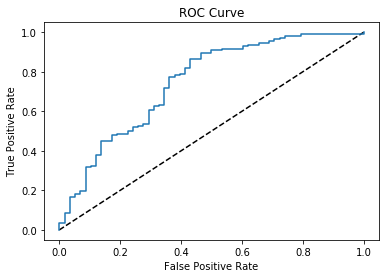

In [49]:
Y_pred_prob = new_xgb.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(Y_test, Y_pred_prob)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

# Measure Fairness

## (a) Anti-classification

## 1. Gender
Reverse the sex in test data and see if any prediction changes.

In [75]:
sex_ind = list(encoded.columns).index('Sex_male')
X_test_sex = np.copy(X_test)
X_test_sex[:, sex_ind] = 1 - X_test_sex[:, sex_ind]

In [76]:
Y_pred_sex = new_xgb.predict(X_test_sex)

In [77]:
print("Percentage of consistent result: ")
print(sum(Y_pred == Y_pred_sex) / len(Y_pred))

Percentage of consistent result: 
0.99


## 2. Age
Randomly assign new age and see if any inconsistencies.

In [78]:
age_ind = list(encoded.columns).index('Age in years')
X_test_age = np.copy(X_test)
X_test_age[:, age_ind] = np.random.rand(len(X_test))

In [81]:
Y_pred_age = new_xgb.predict(X_test_age)

In [82]:
print("Percentage of consistent result: ")
print(sum(Y_pred == Y_pred_age) / len(Y_pred))

Percentage of consistent result: 
0.95


## (b) Independence

In [123]:
full_test = pd.DataFrame(X_test, columns=list(encoded.columns)[:-1])

In [230]:
full_test['Pred'] = Y_pred
full_test['Actual'] = Y_test.values

## 1. Gender

In [231]:
male_test = full_test[full_test['Sex_male'] == 1]
print('Male: ', round(sum(male_test['Pred'] == 1) / len(male_test), 2))

Male:  0.78


In [232]:
female_test = full_test[full_test['Sex_male'] == 0]
print('Female: ', round(sum(female_test['Pred'] == 1) / len(female_test), 2))

Female:  0.69


## 2. Age

In [233]:
min_age = encoded['Age in years'].min()
max_age = encoded['Age in years'].max()
print(min_age, max_age)

19 75


In [264]:
mid = 40
threshold = (mid - min_age) / (max_age - min_age)

In [265]:
young_test = full_test[full_test['Age in years'] <= threshold]
print('Young: ', round(sum(young_test['Pred'] == 1) / len(young_test), 2))

Young:  0.73


In [266]:
old_test = full_test[full_test['Age in years'] > threshold]
print('Old: ', round(sum(old_test['Pred'] == 1) / len(old_test), 2))

Old:  0.82


## (c) Separation

## 1. Gender

In [237]:
male_bad_test = male_test[male_test['Actual'] == 0]
male_good_test = male_test[male_test['Actual'] == 1]
female_bad_test = female_test[female_test['Actual'] == 0]
female_good_test = female_test[female_test['Actual'] == 1]

In [239]:
print('False Positive (Male): ', round(sum(male_bad_test['Pred'] == 1) / len(male_bad_test), 2))

False Positive (Male):  0.48


In [240]:
print('False Positive (Female): ', round(sum(female_bad_test['Pred'] == 1) / len(female_bad_test), 2))

False Positive (Female):  0.44


In [241]:
print('False Negative (Male): ', round(sum(male_good_test['Pred'] == 0) / len(male_good_test), 2))

False Negative (Male):  0.12


In [242]:
print('False Negative (Female): ', round(sum(female_good_test['Pred'] == 0) / len(female_good_test), 2))

False Negative (Female):  0.17


## 2. Age

In [267]:
young_bad_test = young_test[young_test['Actual'] == 0]
young_good_test = young_test[young_test['Actual'] == 1]
old_bad_test = old_test[old_test['Actual'] == 0]
old_good_test = old_test[old_test['Actual'] == 1]

In [272]:
print('False Positive (Young): ', round(sum(young_bad_test['Pred'] == 1) / len(young_bad_test), 2))

False Positive (Young):  0.45


In [273]:
print('False Positive (Old): ', round(sum(old_bad_test['Pred'] == 1) / len(old_bad_test), 2))

False Positive (Old):  0.55


In [270]:
print('False Negative (Young): ', round(sum(young_good_test['Pred'] == 0) / len(young_good_test), 2))

False Negative (Young):  0.15


In [271]:
print('False Negative (Old): ', round(sum(old_good_test['Pred'] == 0) / len(old_good_test), 2))

False Negative (Old):  0.09


# Improve Fairness

For this part, we will try to improve fairness against gender.

## (a) Anti-classification

In [170]:
new_encoded = encoded.drop(columns=['Sex_male'])
new_train, new_test = train_test_split(new_encoded, test_size=0.2, random_state=0)
new_X = new_train.drop(columns=[target]).values
new_Y = new_train[target]
new_scaler = MinMaxScaler()
new_X = new_scaler.fit_transform(new_X)
new_model = XGBClassifier()
new_xgb_params = {'learning_rate': [0.03, 0.1, 0.3, 1],
                  'max_depth': [3, 4, 5, 6, 7],
                  'min_child_weight': [1, 2, 3, 4, 5]}
new_xgb = XGBClassifier(random_state=0, verbosity=0)
new_xgb_cv_model = GridSearchCV(new_xgb, new_xgb_params, cv=5, verbose=5, scoring='accuracy', refit=True, n_jobs=6, return_train_score=True)
new_xgb_cv_model.fit(new_X, new_Y)
print(new_xgb_cv_model.best_params_)

new_xgb_cv_results = pd.DataFrame(new_xgb_cv_model.cv_results_)
new_xgb_best_result = new_xgb_cv_results[new_xgb_cv_results['rank_test_score'] == 1].iloc[0]
new_xgb_avg_val_score, new_xgb_std_val_score = new_xgb_best_result[['mean_test_score', 'std_test_score']]
new_xgb_avg_train_score, new_xgb_std_train_score = new_xgb_best_result[['mean_train_score', 'std_train_score']]

new_xgb_split_results = new_xgb_best_result[[idx for idx in new_xgb_best_result.index if 'split' in idx]]

print('TRAINING CV RESULTS (Accuracy)')
print('Train:')
print('Mean: ', new_xgb_avg_train_score)
print('Std. Dev.: ', new_xgb_std_train_score)
print('Validation:')
print('Mean: ', new_xgb_avg_val_score)
print('Std. Dev.: ', new_xgb_std_val_score)
print('Scores:')
print(new_xgb_split_results.astype(float).to_string())


Fitting 5 folds for each of 100 candidates, totalling 500 fits
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   6 tasks      | elapsed:    0.2s
[Parallel(n_jobs=6)]: Done 108 tasks      | elapsed:    4.9s
[Parallel(n_jobs=6)]: Done 288 tasks      | elapsed:   12.6s
{'learning_rate': 0.3, 'max_depth': 4, 'min_child_weight': 4}
TRAINING CV RESULTS (Accuracy)
Train:
Mean:  0.9821875
Std. Dev.:  0.005555121510822239
Validation:
Mean:  0.76875
Std. Dev.:  0.018540496217739174
Scores:
split0_test_score     0.800000
split1_test_score     0.750000
split2_test_score     0.775000
split3_test_score     0.750000
split4_test_score     0.768750
split0_train_score    0.984375
split1_train_score    0.987500
split2_train_score    0.981250
split3_train_score    0.971875
split4_train_score    0.985938
[Parallel(n_jobs=6)]: Done 500 out of 500 | elapsed:   25.1s finished


In [171]:
new_new_xgb = XGBClassifier(learning_rate=0.3, max_depth=4, min_child_weight=4, random_state=0, verbosity=0)
new_new_xgb.fit(new_X, new_Y)
filename = 'model_anti.sav'
pickle.dump(new_new_xgb, open(filename, 'wb'))

Accuracy:  75.0


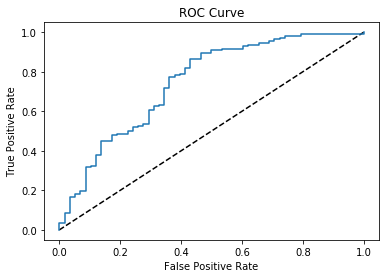

In [174]:
new_X_test = new_test.drop(columns=[target]).values
new_Y_test = new_test[target]
new_X_test = new_scaler.transform(new_X_test)
new_Y_pred = new_new_xgb.predict(new_X_test)
print("Accuracy: ", round(accuracy_score(new_Y_test, new_Y_pred) * 100, 2))
new_Y_pred_prob = new_new_xgb.predict_proba(new_X_test)[:, 1]
n_fpr, n_tpr, n_thresholds = roc_curve(new_Y_test, new_Y_pred_prob)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

## (b) Independence

In [244]:
new_full_test = pd.DataFrame(X_test, columns=list(encoded.columns)[:-1])

In [245]:
new_full_test['Pred_prob'] = Y_pred_prob
new_full_test['Actual'] = Y_test.values

In [278]:
candidates_ind = [0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7]
max_diff = 0.005

In [279]:
for t in candidates_ind:
    for h in candidates_ind:
        new_male_test = new_full_test[new_full_test['Sex_male'] == 1]
        male_good = round(sum(new_male_test['Pred_prob'] > t) / len(new_male_test), 2)
        new_female_test = new_full_test[new_full_test['Sex_male'] == 0]
        female_good = round(sum(new_female_test['Pred_prob'] > h) / len(new_female_test), 2)
        if abs(male_good - female_good) < max_diff:
            print("Threshold: ", (t, h))
            print('Male: ' + str(male_good) + ', Female: ' + str(female_good))
            print('Gender difference: ', round(male_good - female_good, 2))
            overall_acc = round((sum(new_male_test['Pred_prob'] > t) + sum(new_female_test['Pred_prob'] > h)) / len(new_full_test), 2)
            print('Overall accuracy: ', overall_acc)
            print('-----------------------------')

Threshold:  (0.7, 0.5)
Male: 0.69, Female: 0.69
Gender difference:  0.0
Overall accuracy:  0.69
-----------------------------
Threshold:  (0.7, 0.55)
Male: 0.69, Female: 0.69
Gender difference:  0.0
Overall accuracy:  0.69
-----------------------------


## (c) Separation

In [248]:
new_male_bad_test = new_male_test[new_male_test['Actual'] == 0]
new_male_good_test = new_male_test[new_male_test['Actual'] == 1]
new_female_bad_test = new_female_test[new_female_test['Actual'] == 0]
new_female_good_test = new_female_test[new_female_test['Actual'] == 1]

In [276]:
candidates_ind = [0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7]
max_diff = 0.02

In [277]:
for t in candidates_ind:
    for h in candidates_ind:
        male_fp = round(sum(new_male_bad_test['Pred_prob'] > t) / len(new_male_bad_test), 2)
        female_fp = round(sum(new_female_bad_test['Pred_prob'] > h) / len(new_female_bad_test), 2)
        male_fn = round(sum(new_male_good_test['Pred_prob'] > t) / len(new_male_good_test), 2)
        female_fn = round(sum(new_female_good_test['Pred_prob'] > h) / len(new_female_good_test), 2)
        if abs(male_fp - female_fp) < max_diff and abs(male_fn - female_fn) < max_diff:
            print("Threshold: ", (t, h))
            print('FP (male, female): ' + str(male_fp) + ', ' + str(female_fp) + ', FN: ' + str(male_fn) + ', ' + str(female_fn))
            print('Gender difference:')
            print('FP: ', round(male_fp - female_fp, 2))
            print('FN: ', round(male_fn - female_fn, 2))
            overall_acc = round((sum(new_male_test['Pred_prob'] > t) + sum(new_female_test['Pred_prob'] > h)) / len(new_full_test), 2)
            print('Overall accuracy: ', overall_acc)
            print('-----------------------------')

Threshold:  (0.5, 0.4)
FP (male, female): 0.48, 0.48, FN: 0.88, 0.87
Gender difference:
FP:  0.0
FN:  0.01
Overall accuracy:  0.77
-----------------------------
